### Generate the labels

In [2]:
# Step 1: Create labels from the filenames in a data folder.
# - Adjust ROOT to your local path for 'data3' before running (e.g., r"C:\...\data3" or "/home/user/data3").
# - This will write /mnt/data/labels.csv here in the notebook environment.
# - If ROOT exists here, it will also show you a preview of the labels.

import os, csv, pathlib, sys
from typing import List, Dict

try:
    from caas_jupyter_tools import display_dataframe_to_user
except Exception:
    display_dataframe_to_user = None

import pandas as pd

# --------- CONFIG ---------
# Set this to your data3 folder path
ROOT = "/data/scp6004/xai-data1/data2"  # change this to your local path if running outside this environment
OUT_CSV = "/data/scp6004/xai-data1/labels2.csv"
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
# --------------------------

def is_image(fname: str) -> bool:
    return pathlib.Path(fname).suffix.lower() in IMG_EXTS

def build_labels(root: str) -> List[Dict[str, str]]:
    rows = []
    for dirpath, _, files in os.walk(root):
        for f in files:
            if not is_image(f):
                continue
            name = f.lower()
            if name.startswith("good"):
                label = 1
            elif name.startswith("bad"):
                label = 0
            else:
                # skip files that don't follow the convention
                continue
            rows.append({"path": os.path.join(dirpath, f), "filename": f, "label": label})
    rows.sort(key=lambda r: r["filename"].lower())
    return rows

def write_csv(rows: List[Dict[str, str]], out_csv: str) -> None:
    os.makedirs(os.path.dirname(os.path.abspath(out_csv)) or ".", exist_ok=True)
    with open(out_csv, "w", newline="") as fp:
        writer = csv.DictWriter(fp, fieldnames=["path", "filename", "label"])
        writer.writeheader()
        writer.writerows(rows)

# Create labels if ROOT exists
if os.path.isdir(ROOT):
    rows = build_labels(ROOT)
    write_csv(rows, OUT_CSV)
    df = pd.DataFrame(rows)
    # Show a quick preview
    print(f"Wrote {len(rows)} rows to {OUT_CSV}")
    if not df.empty:
        print(df.head(10).to_string(index=False))
        if display_dataframe_to_user is not None:
            display_dataframe_to_user("labels_preview", df.head(200))
else:
    # If the folder doesn't exist here, just create a ready-to-run script for you to download.
    script_path = "/mnt/data/labels_from_filenames.py"
    script = r'''#!/usr/bin/env python3
import os, csv, argparse, pathlib

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

def is_image(fname: str) -> bool:
    return pathlib.Path(fname).suffix.lower() in IMG_EXTS

def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--root", required=True, help="Path to data folder (e.g., data3)")
    ap.add_argument("--out", default="labels.csv", help="Output CSV file")
    args = ap.parse_args()

    rows = []
    for dirpath, _, files in os.walk(args.root):
        for f in files:
            if not is_image(f):
                continue
            name = f.lower()
            if name.startswith("good"):
                label = 1
            elif name.startswith("bad"):
                label = 0
            else:
                continue
            rows.append({"path": os.path.join(dirpath, f), "filename": f, "label": label})

    rows.sort(key=lambda r: r["filename"].lower())
    os.makedirs(os.path.dirname(os.path.abspath(args.out)) or ".", exist_ok=True)
    with open(args.out, "w", newline="") as fp:
        writer = csv.DictWriter(fp, fieldnames=["path", "filename", "label"])
        writer.writeheader()
        writer.writerows(rows)

    print(f"Wrote {len(rows)} rows to {args.out}")

if __name__ == "__main__":
    main()
'''
    with open(script_path, "w", encoding="utf-8") as f:
        f.write(script)
    print("data3 folder not found at:", ROOT)
    print("Download the helper script and run it locally, e.g.:")
    print("  python labels_from_filenames.py --root /PATH/TO/data3 --out labels.csv")
    print("Helper script written to:", script_path)


Wrote 1900 rows to /data/scp6004/xai-data1/labels2.csv
                                                                                            path                                                           filename  label
/data/scp6004/xai-data1/data2/bad_easy_Ag20Cu40Co20Ni20_p0001_0050k_20220112T200859.438Raw0.jpeg bad_easy_Ag20Cu40Co20Ni20_p0001_0050k_20220112T200859.438Raw0.jpeg      0
/data/scp6004/xai-data1/data2/bad_easy_Ag20Cu40Co20Ni20_p0001_0050k_20220112T200900.432Raw1.jpeg bad_easy_Ag20Cu40Co20Ni20_p0001_0050k_20220112T200900.432Raw1.jpeg      0
/data/scp6004/xai-data1/data2/bad_easy_Ag20Cu40Co20Ni20_p0001_0100k_20220112T200902.686Raw0.jpeg bad_easy_Ag20Cu40Co20Ni20_p0001_0100k_20220112T200902.686Raw0.jpeg      0
/data/scp6004/xai-data1/data2/bad_easy_Ag20Cu40Co20Ni20_p0001_0100k_20220112T200903.682Raw1.jpeg bad_easy_Ag20Cu40Co20Ni20_p0001_0100k_20220112T200903.682Raw1.jpeg      0
/data/scp6004/xai-data1/data2/bad_easy_Ag20Cu40Co20Ni20_p0001_0100k_20220112T200904.780Raw

### Use the model.pth on the images in data and check with the labels how good the model is

In [3]:
# This cell writes a Python script that will:
# - Load an unknown model checkpoint (TorchScript or state_dict).
# - Build labels from filenames if labels.csv is missing.
# - Run inference on images in data3.
# - Compare against labels and report metrics.
# - Save per-image predictions to predictions.csv and confusion_matrix.png.
#
# Usage (locally):
#   python eval_unknown_model.py --model /PATH/TO/model.pth --root /PATH/TO/data3 --labels labels.csv
#
# If --labels is omitted, it will be created automatically from filenames (good*/bad*).

import os, textwrap, pathlib

script = r'''#!/usr/bin/env python3
import os, argparse, csv, pathlib, json
from typing import List, Dict, Tuple, Optional

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
IMG_SIZE = 512

def is_image(fname: str) -> bool:
    return pathlib.Path(fname).suffix.lower() in IMG_EXTS

def build_labels_from_filenames(root: str) -> pd.DataFrame:
    rows: List[Dict[str, str]] = []
    for dirpath, _, files in os.walk(root):
        for f in files:
            if not is_image(f):
                continue
            name = f.lower()
            if name.startswith("good"):
                label = 1
            elif name.startswith("bad"):
                label = 0
            else:
                continue
            rows.append({"path": os.path.join(dirpath, f), "filename": f, "label": label})
    rows.sort(key=lambda r: r["filename"].lower())
    return pd.DataFrame(rows)

class ImageCsvDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df.reset_index(drop=True)
        self.base_tf = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["path"]).convert("L")
        img = self.base_tf(img)
        # per-image standardization
        mean = img.mean()
        std = img.std()
        std = std if std > 1e-6 else torch.tensor(1e-6)
        img = (img - mean) / std
        label = torch.tensor(row["label"], dtype=torch.float32)
        return img, label, row["filename"]

def build_model() -> nn.Module:
    m = models.resnet18(weights=None)
    in_feats = m.fc.in_features
    m.fc = nn.Linear(in_feats, 1)
    return m

def smart_load_model(path: str, device: str = "cpu", model_def=build_model) -> Tuple[nn.Module, str]:
    # Try TorchScript first
    try:
        jit = torch.jit.load(path, map_location=device)
        print("Loaded TorchScript model.")
        jit.eval().to(device)
        return jit, "torchscript"
    except Exception:
        pass
    # Fallback: state_dict-like
    obj = torch.load(path, map_location=device)
    if isinstance(obj, dict):
        sd = None
        kind = "state_dict"
        if "state_dict" in obj and isinstance(obj["state_dict"], dict):
            sd = obj["state_dict"]
            kind = "wrapped_state_dict"
        elif all(isinstance(k, str) for k in obj.keys()):
            sd = obj
            kind = "state_dict"
        else:
            raise RuntimeError("Unknown checkpoint dictionary structure.")
        model = model_def()
        # strip 'module.' prefixes if any
        new_sd = { (k.replace("module.","") if k.startswith("module.") else k): v for k,v in sd.items() }
        model.load_state_dict(new_sd, strict=False)
        model.eval().to(device)
        print(f"Loaded weights into default model ({kind}).")
        return model, kind
    else:
        raise RuntimeError("Unsupported .pth format; not TorchScript and not a dict-like state_dict.")

def evaluate(model: nn.Module, loader: DataLoader, device: str = "cpu") -> Dict:
    model.eval()
    y_true, y_prob, fnames = [], [], []
    with torch.no_grad():
        for x, y, f in loader:
            x = x.to(device)
            logits = model(x).squeeze(1)
            probs = torch.sigmoid(logits).cpu().numpy().tolist()
            y_prob.extend(probs)
            y_true.extend(y.numpy().tolist())
            fnames.extend(list(f))

    y_true = np.array(y_true, dtype=int)
    y_prob = np.array(y_prob, dtype=float)
    y_pred = (y_prob >= 0.5).astype(int)

    report = classification_report(y_true, y_pred, target_names=["bad(0)","good(1)"], digits=4, output_dict=False)
    cm = confusion_matrix(y_true, y_pred)
    try:
        auc = roc_auc_score(y_true, y_prob)
    except Exception:
        auc = float("nan")

    print(report)
    print("Confusion matrix:\n", cm)
    print("ROC-AUC:", auc)

    return {
        "y_true": y_true.tolist(),
        "y_prob": y_prob.tolist(),
        "y_pred": y_pred.tolist(),
        "filenames": fnames,
        "confusion_matrix": cm.tolist(),
        "roc_auc": auc,
        "report_text": report,
    }

def save_predictions_csv(df: pd.DataFrame, metrics: Dict, out_csv: str):
    out = pd.DataFrame({
        "filename": metrics["filenames"],
        "label": metrics["y_true"],
        "prob_good": metrics["y_prob"],
        "pred": metrics["y_pred"],
    })
    # Merge to keep full paths if present
    df_small = df[["filename","path"]] if "path" in df.columns else df[["filename"]].copy()
    merged = out.merge(df_small, on="filename", how="left")
    merged.to_csv(out_csv, index=False)
    print(f"Saved per-image predictions to {out_csv}")

def save_confusion_matrix(cm, out_png="confusion_matrix.png"):
    import numpy as np
    plt.figure()
    plt.imshow(np.array(cm), interpolation='nearest')
    plt.title("Confusion Matrix")
    plt.colorbar()
    ticks = np.arange(2)
    plt.xticks(ticks, ["bad(0)", "good(1)"])
    plt.yticks(ticks, ["bad(0)", "good(1)"])
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.savefig(out_png, dpi=150)
    print(f"Saved confusion matrix to {out_png}")

def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--model", required=True, help="Path to model.pth / best_model.pth")
    ap.add_argument("--root", required=True, help="Path to data folder (e.g., data3)")
    ap.add_argument("--labels", default=None, help="Path to labels.csv (optional). If not provided, created from filenames.")
    ap.add_argument("--batch-size", type=int, default=32)
    args = ap.parse_args()

    if args.labels and os.path.isfile(args.labels):
        df = pd.read_csv(args.labels)
        assert {"filename","label"}.issubset(df.columns), "labels.csv must have filename,label columns (path optional)"
    else:
        print("No labels.csv provided or found. Building labels from filenames...")
        df = build_labels_from_filenames(args.root)
        if df.empty:
            raise SystemExit("No labeled images found in the folder (filenames must start with 'good' or 'bad').")
        built_labels = os.path.join(os.getcwd(), "labels.csv")
        df.to_csv(built_labels, index=False)
        print(f"Wrote {len(df)} labels to {built_labels}")

    dataset = ImageCsvDataset(df)
    loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False, num_workers=4, pin_memory=True)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, kind = smart_load_model(args.model, device=device)

    # If TorchScript, ensure a wrapper that outputs logits->sigmoid:
    if kind == "torchscript":
        # assume the script returns logits directly; otherwise adapt here
        pass

    metrics = evaluate(model, loader, device=device)
    save_predictions_csv(df, metrics, out_csv="predictions.csv")
    save_confusion_matrix(metrics["confusion_matrix"], out_png="confusion_matrix.png")

    with open("metrics.json", "w") as f:
        json.dump({"roc_auc": metrics["roc_auc"], "confusion_matrix": metrics["confusion_matrix"]}, f, indent=2)
    print("Saved metrics.json")

if __name__ == "__main__":
    main()
'''
out_path = "/data/scp6004/xai-data1/eval_unknown_model.py"
with open(out_path, "w", encoding="utf-8") as f:
    f.write(script)

print("Wrote", out_path)
print("Run locally, e.g.:")
print("  python eval_unknown_model.py --model /data/scp6004/xai-data1/model.pth --root /data/scp6004/xai-data1/data3 --labels /data/scp6004/xai-data1/labels.csv")


Wrote /data/scp6004/xai-data1/eval_unknown_model.py
Run locally, e.g.:
  python eval_unknown_model.py --model /data/scp6004/xai-data1/model.pth --root /data/scp6004/xai-data1/data3 --labels /data/scp6004/xai-data1/labels.csv


### Doing some plotting for the MicroscopyGPT project with the output csv files

Metrics (filtered to stoichiometry_match == True):
         n      MAE     RMSE
param                       
a      281 0.327972 0.590725
alpha  281        0        0
b      281 0.311673 0.577613
beta   281        0        0
c      281 0.349395 0.657342
gamma  281   4.6121  11.3344

Sanity check (mean of provided *_mae col vs recomputed MAE):
       mean(provided_mae_col)  MAE(recomputed)
a                    0.327972         0.327972
b                    0.311673         0.311673
c                    0.349395         0.349395
alpha                       0                0
beta                        0                0
gamma                  4.6121           4.6121


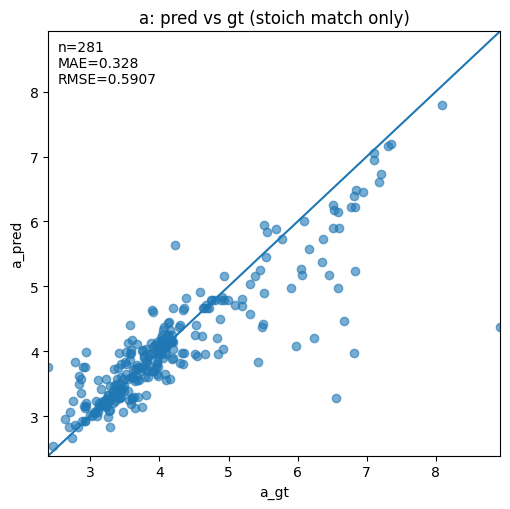

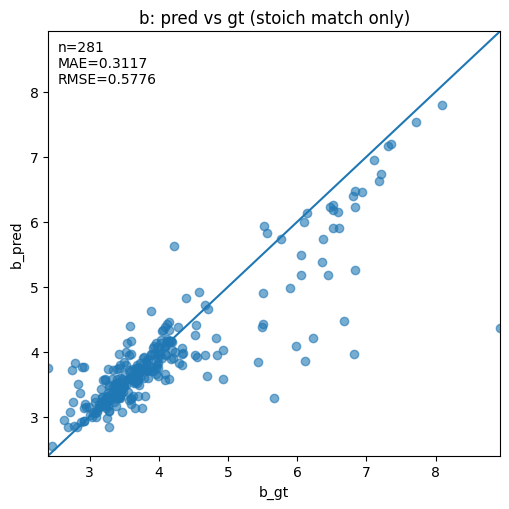

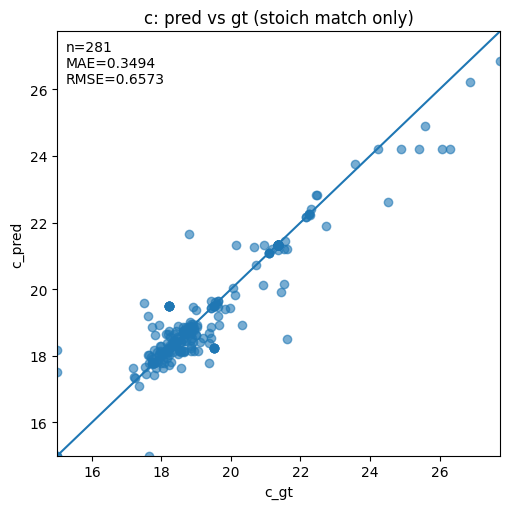

/tmp/ipykernel_194065/28665721.py:83: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(lo, hi)
/tmp/ipykernel_194065/28665721.py:84: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(lo, hi)


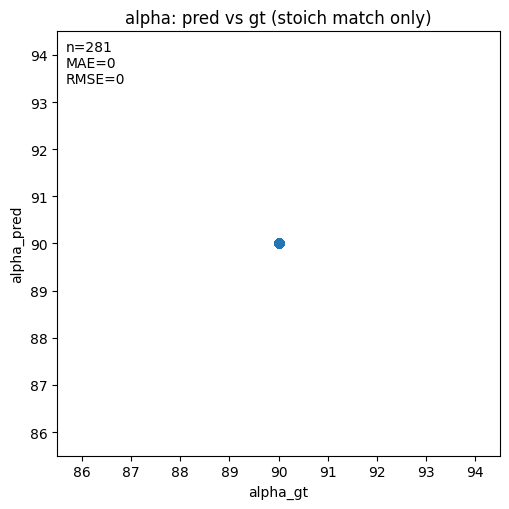

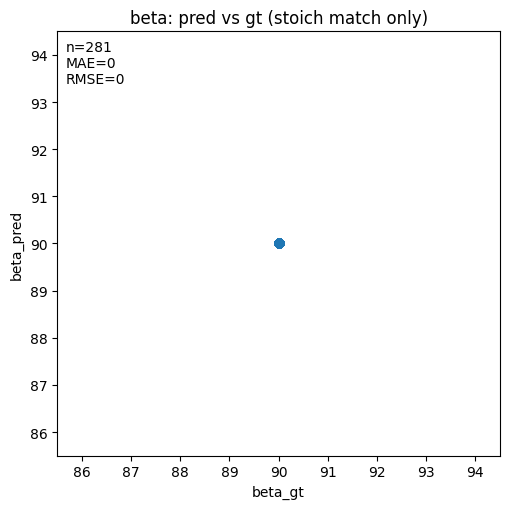

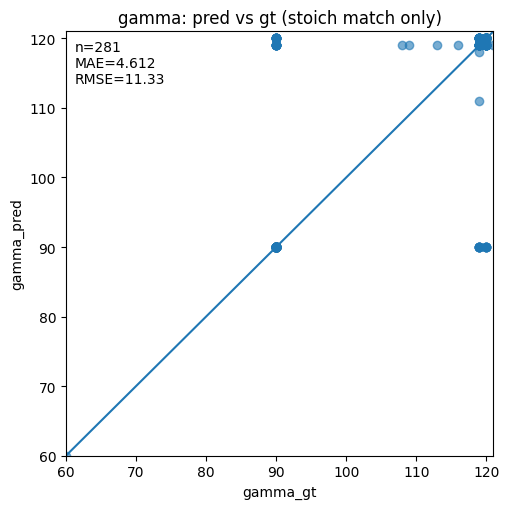

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# Load + filter
# -----------------------
csv_path = "qwen2-c2db-reload.csv"  # <-- change this
df = pd.read_csv(csv_path)

# If stoichiometry_match is read as strings like "True"/"False", normalize to bool
if df["stoichiometry_match"].dtype == object:
    df["stoichiometry_match"] = df["stoichiometry_match"].astype(str).str.lower().map({"true": True, "false": False})

df_m = df[df["stoichiometry_match"] == True].copy()

# -----------------------
# Metrics (MAE / RMSE)
# -----------------------
params = ["a", "b", "c", "alpha", "beta", "gamma"]

def mae(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    return np.mean(np.abs(x - y))

def rmse(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    return np.sqrt(np.mean((x - y) ** 2))

metrics = []
for p in params:
    gt = df_m[f"{p}_gt"]
    pred = df_m[f"{p}_pred"]
    metrics.append(
        {
            "param": p,
            "n": int(gt.notna().sum() & pred.notna().sum()),
            "MAE": mae(gt, pred),
            "RMSE": rmse(gt, pred),
        }
    )

metrics_df = pd.DataFrame(metrics).set_index("param").sort_index()
print("Metrics (filtered to stoichiometry_match == True):")
print(metrics_df.to_string(float_format=lambda v: f"{v:.6g}"))

# Optional: sanity-check vs provided *_mae columns (if they exist)
provided_mae_cols = [f"{p}_mae" for p in params if f"{p}_mae" in df_m.columns]
if provided_mae_cols:
    check = {}
    for p in params:
        col = f"{p}_mae"
        if col in df_m.columns:
            check[p] = {
                "mean(provided_mae_col)": float(pd.to_numeric(df_m[col], errors="coerce").mean()),
                "MAE(recomputed)": float(metrics_df.loc[p, "MAE"]),
            }
    print("\nSanity check (mean of provided *_mae col vs recomputed MAE):")
    print(pd.DataFrame(check).T.to_string(float_format=lambda v: f"{v:.6g}"))

# -----------------------
# Scatter plots: pred vs gt
# -----------------------
def scatter_pred_vs_gt(df_in, params, use_equal_axes=True):
    for p in params:
        gt = pd.to_numeric(df_in[f"{p}_gt"], errors="coerce")
        pred = pd.to_numeric(df_in[f"{p}_pred"], errors="coerce")
        mask = gt.notna() & pred.notna()
        x = gt[mask].to_numpy()
        y = pred[mask].to_numpy()

        fig, ax = plt.subplots(figsize=(5.2, 5.2))
        ax.scatter(x, y, alpha=0.6)

        # y = x reference line
        if len(x) > 0:
            lo = np.nanmin([x.min(), y.min()])
            hi = np.nanmax([x.max(), y.max()])
            ax.plot([lo, hi], [lo, hi])
            if use_equal_axes:
                ax.set_xlim(lo, hi)
                ax.set_ylim(lo, hi)

        ax.set_title(f"{p}: pred vs gt (stoich match only)")
        ax.set_xlabel(f"{p}_gt")
        ax.set_ylabel(f"{p}_pred")

        # annotate with metrics
        ax.text(
            0.02, 0.98,
            f"n={mask.sum()}\nMAE={mae(x, y):.4g}\nRMSE={rmse(x, y):.4g}",
            transform=ax.transAxes,
            va="top",
        )

        plt.tight_layout()
        plt.show()

scatter_pred_vs_gt(df_m, params)

# -----------------------
# Optional: combined 2x3 grid
# -----------------------
def scatter_grid(df_in, params):
    fig, axes = plt.subplots(2, 3, figsize=(13, 8))
    axes = axes.ravel()

    for ax, p in zip(axes, params):
        gt = pd.to_numeric(df_in[f"{p}_gt"], errors="coerce")
        pred = pd.to_numeric(df_in[f"{p}_pred"], errors="coerce")
        mask = gt.notna() & pred.notna()
        x = gt[mask].to_numpy()
        y = pred[mask].to_numpy()

        ax.scatter(x, y, alpha=0.6)
        if len(x) > 0:
            lo = np.nanmin([x.min(), y.min()])
            hi = np.nanmax([x.max(), y.max()])
            ax.plot([lo, hi], [lo, hi])
            ax.set_xlim(lo, hi)
            ax.set_ylim(lo, hi)

        ax.set_title(p)
        ax.set_xlabel("gt")
        ax.set_ylabel("pred")
        ax.text(
            0.02, 0.98,
            f"n={mask.sum()}\nMAE={mae(x, y):.4g}\nRMSE={rmse(x, y):.4g}",
            transform=ax.transAxes,
            va="top",
        )

    plt.suptitle("Predicted vs Ground Truth (stoichiometry_match == True)", y=1.02)
    plt.tight_layout()
    plt.show()

# Uncomment if you want the grid view too
# scatter_grid(df_m, params)


### Looking at the common formulas where the stoichiometry match across all the models and calculating those MSE/MAE

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple

# -----------------------
# Config (edit these)
# -----------------------
paths = {
    "qwen":  "qwen2-c2db-reload.csv",
    "gemma": "gemma-c2db-reload.csv",
    "llama": "llama3.2-c2db-reload.csv",
}
# Only these params will be evaluated and compared
PARAMS = ["a", "b", "c", "gamma"]


# -----------------------
# Helpers
# -----------------------
def _to_bool_series(s: pd.Series) -> pd.Series:
    """Normalize potentially string 'True'/'False' to booleans, safely handling NaN."""
    if s.dtype == bool:
        return s
    return s.astype(str).str.strip().str.lower().map({"true": True, "false": False})


def mae(x, y) -> float:
    x = np.asarray(pd.to_numeric(x, errors="coerce"), dtype=float)
    y = np.asarray(pd.to_numeric(y, errors="coerce"), dtype=float)
    mask = np.isfinite(x) & np.isfinite(y)
    if not mask.any():
        return float("nan")
    return float(np.mean(np.abs(x[mask] - y[mask])))


def rmse(x, y) -> float:
    x = np.asarray(pd.to_numeric(x, errors="coerce"), dtype=float)
    y = np.asarray(pd.to_numeric(y, errors="coerce"), dtype=float)
    mask = np.isfinite(x) & np.isfinite(y)
    if not mask.any():
        return float("nan")
    return float(np.sqrt(np.mean((x[mask] - y[mask]) ** 2)))


def load_and_filter(path: str) -> pd.DataFrame:
    """Load a single CSV, normalize booleans, filter to stoichiometry_match == True."""
    df = pd.read_csv(path)
    if "stoichiometry_match" not in df.columns:
        raise ValueError(f"{path}: missing 'stoichiometry_match' column")
    df["stoichiometry_match"] = _to_bool_series(df["stoichiometry_match"])
    df = df[df["stoichiometry_match"] == True].copy()
    return df


def choose_key_column(frames: Dict[str, pd.DataFrame]) -> str:
    """
    Choose a join key present in all frames, preferring 'id', then 'target_formula'.
    Raise if neither is common.
    """
    candidates = ["id", "target_formula"]
    for key in candidates:
        if all(key in df.columns for df in frames.values()):
            return key
    raise ValueError("No common key column found. Need 'id' or 'target_formula' in all CSVs.")


def reduce_and_rename(df: pd.DataFrame, key: str, model: str, params: List[str]) -> pd.DataFrame:
    """
    Keep key, *_gt, *_pred for requested params.
    Suffix the *_pred columns with _{model} so they are distinct after merging.
    Keep *_gt without suffix (we will check consistency across models).
    """
    needed = [key]
    for p in params:
        gtc = f"{p}_gt"
        prc = f"{p}_pred"
        if gtc not in df.columns or prc not in df.columns:
            raise ValueError(f"Missing columns in model={model}: required '{gtc}' and '{prc}'")
        needed += [gtc, prc]
    out = df[needed].copy()

    # rename preds only
    out = out.rename(columns={f"{p}_pred": f"{p}_pred_{model}" for p in params})
    return out


def inner_join_common_matches(reduced: Dict[str, pd.DataFrame], key: str) -> pd.DataFrame:
    """Inner-join all reduced frames on the key to keep only rows where all models matched."""
    models = list(reduced.keys())
    merged = reduced[models[0]]
    for m in models[1:]:
        merged = merged.merge(reduced[m], on=[key] + [f"{p}_gt" for p in PARAMS], how="inner")
    return merged


def check_gt_consistency(merged: pd.DataFrame) -> None:
    """
    Ground-truth columns come from the first DF but were also required in the merge keys,
    so they are already consistent. Keep this stub for clarity and future extension.
    """


def compute_metrics_common(merged: pd.DataFrame, params: List[str], models: List[str]) -> pd.DataFrame:
    """
    Build a tidy metrics table indexed by [param] with columns like:
      n_<model>, MAE_<model>, RMSE_<model>
    """
    rows = { "param": [] }
    # Initialize per-model columns
    for m in models:
        rows[f"n_{m}"] = []
        rows[f"MAE_{m}"] = []
        rows[f"RMSE_{m}"] = []

    for p in params:
        rows["param"].append(p)
        gt = merged[f"{p}_gt"]
        for m in models:
            pred = merged[f"{p}_pred_{m}"]
            mask = gt.notna() & pred.notna()
            rows[f"n_{m}"].append(int(mask.sum()))
            rows[f"MAE_{m}"].append(mae(gt[mask], pred[mask]))
            rows[f"RMSE_{m}"].append(rmse(gt[mask], pred[mask]))

    metrics_df = pd.DataFrame(rows).set_index("param")
    return metrics_df


def print_summary(merged: pd.DataFrame, key: str, models: List[str]) -> None:
    print(f"Common matched rows across all models: {len(merged):d}")
    sample = merged[[key] + [f"{p}_gt" for p in PARAMS]].head(3)
    if len(sample) > 0:
        print("\nSample of common keys and GT (first 3 rows):")
        print(sample.to_string(index=False))


def scatter_pred_vs_gt_common(merged: pd.DataFrame, params: List[str], models: List[str], equal_axes=True) -> None:
    """
    Optional: per-param, overlay the three models on a single plot for quick visual comparison.
    """
    for p in params:
        gt = pd.to_numeric(merged[f"{p}_gt"], errors="coerce")
        fig, ax = plt.subplots(figsize=(5.6, 5.6))
        lo, hi = None, None

        # plot each model
        for m in models:
            pred = pd.to_numeric(merged[f"{p}_pred_{m}"], errors="coerce")
            mask = gt.notna() & pred.notna()
            x = gt[mask].to_numpy()
            y = pred[mask].to_numpy()
            ax.scatter(x, y, alpha=0.6, label=m)

            if x.size:
                c_lo = np.nanmin([x.min(), y.min()])
                c_hi = np.nanmax([x.max(), y.max()])
                lo = c_lo if lo is None else min(lo, c_lo)
                hi = c_hi if hi is None else max(hi, c_hi)

        if lo is not None and hi is not None:
            ax.plot([lo, hi], [lo, hi])  # y=x
            if equal_axes:
                ax.set_xlim(lo, hi)
                ax.set_ylim(lo, hi)

        ax.set_title(f"{p}: pred vs gt (intersection of matches)")
        ax.set_xlabel(f"{p}_gt")
        ax.set_ylabel(f"{p}_pred")
        ax.legend(frameon=False)
        plt.tight_layout()
        plt.show()


# -----------------------
# Main
# -----------------------
def main(model_paths: Dict[str, str],
         params: List[str] = PARAMS,
         make_plots: bool = False) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Returns:
        merged_common_df: the joined dataframe restricted to rows where all models matched
        metrics_df:       table of MAE/RMSE per param per model on the common set
    """
    # 1) Load each CSV and filter to stoichiometry_match == True
    filtered = {m: load_and_filter(p) for m, p in model_paths.items()}

    # 2) Pick a join key common to all
    key = choose_key_column(filtered)

    # 3) Reduce and rename
    reduced = {m: reduce_and_rename(df, key, m, params) for m, df in filtered.items()}

    # 4) Keep only rows present in all three (inner join)
    merged_common = inner_join_common_matches(reduced, key)

    # 5) Sanity: GT consistency
    check_gt_consistency(merged_common)

    # 6) Metrics on the common set
    models = list(model_paths.keys())
    metrics_df = compute_metrics_common(merged_common, params, models)

    # 7) Print a concise summary
    print_summary(merged_common, key, models)
    print("\nMetrics on the common matched set (all three models correct):")
    print(metrics_df.to_string(float_format=lambda v: f"{v:.6g}"))

    # 8) Optional plots
    if make_plots and len(merged_common) > 0:
        scatter_pred_vs_gt_common(merged_common, params, models)

    return merged_common, metrics_df


if __name__ == "__main__":
    # Example run; set make_plots=True if you want overlay scatter plots.
    _, metrics = main(paths, params=PARAMS, make_plots=False)

    # Optionally save the metrics for later comparison
    metrics.to_csv("metrics_c2db.csv")
    print("\nSaved: metrics_c2db.csv")

Common matched rows across all models: 204

Sample of common keys and GT (first 3 rows):
                  id  a_gt  b_gt  c_gt  gamma_gt
unknown_id_1x1x1_001  2.63  2.63 17.34     119.0
unknown_id_1x1x1_001  2.71  2.71 18.54      90.0
unknown_id_1x1x1_001  4.19  3.64 21.34      90.0

Metrics on the common matched set (all three models correct):
       n_qwen  MAE_qwen  RMSE_qwen  n_gemma  MAE_gemma  RMSE_gemma  n_llama  MAE_llama  RMSE_llama
param                                                                                             
a         204  0.281569   0.473343      204   0.479167    0.769146      204   0.207941    0.338562
b         204  0.265392   0.458934      204   0.412108    0.724358      204   0.213971    0.384035
c         204  0.390882   0.677618      204   0.631961     1.04485      204   0.412843    0.804598
gamma     204   4.16667    10.7876      204    2.70099     8.58379      204    2.82844     8.78919

Saved: metrics_c2db.csv


### Generating the table as in the paper

       n_gt  n_pred  KLD(gt||pred)  KLD(pred||gt)       JSD       EMD  \
param                                                                   
a        43      43       5.496586      10.246065  0.263274  0.323870   
b        43      43       8.334239       2.624736  0.178213  0.666409   
c        43      43      22.313019      22.314181  0.618633  7.694791   
alpha    43      43       1.598061       0.072321  0.024810  0.990700   
beta     43      43       1.064811       0.047628  0.016397  0.274419   
gamma    43      43       2.180571       0.115583  0.037657  3.418605   

       min_union   max_union  
param                         
a       2.380000    7.820000  
b       2.779997   12.869995  
c      15.460000   35.660000  
alpha  86.000000  122.000100  
beta   82.000000   94.000000  
gamma  60.000000  120.000000  


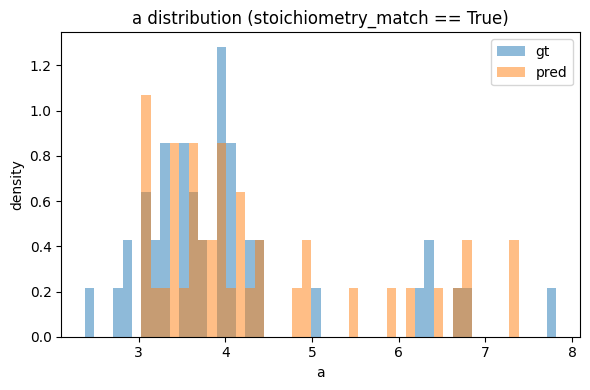

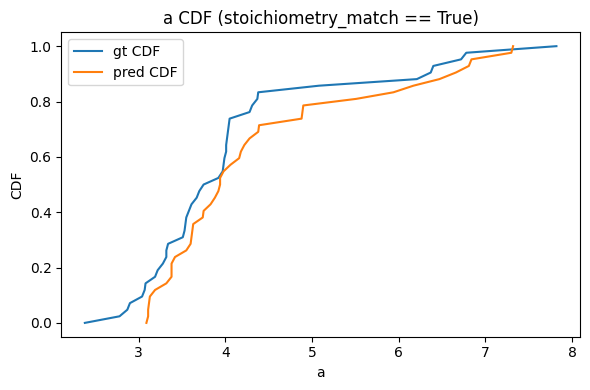

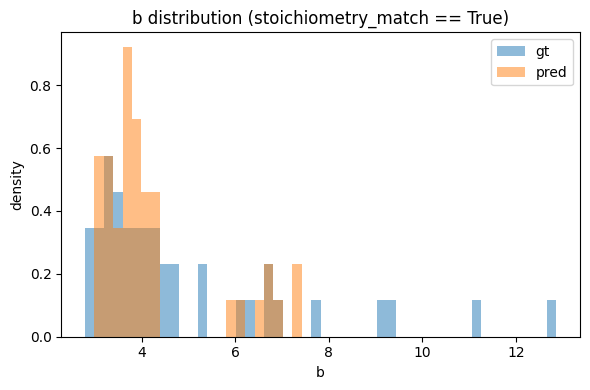

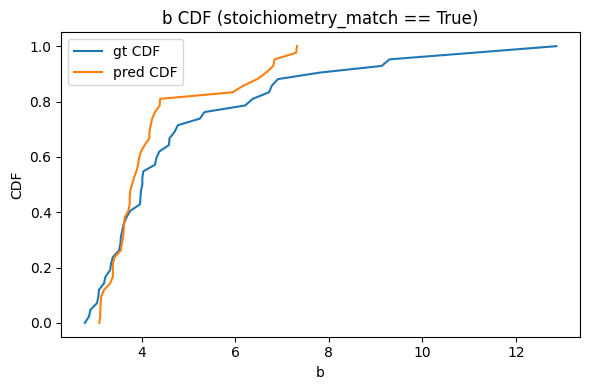

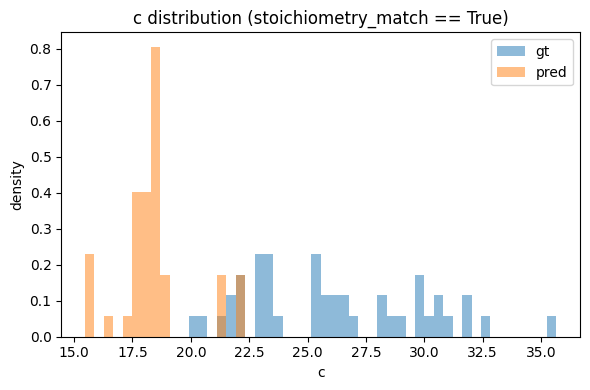

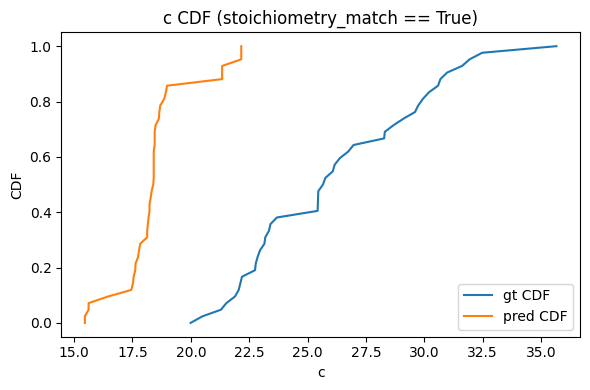

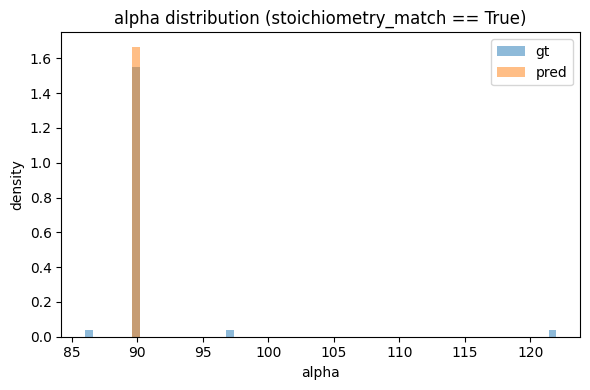

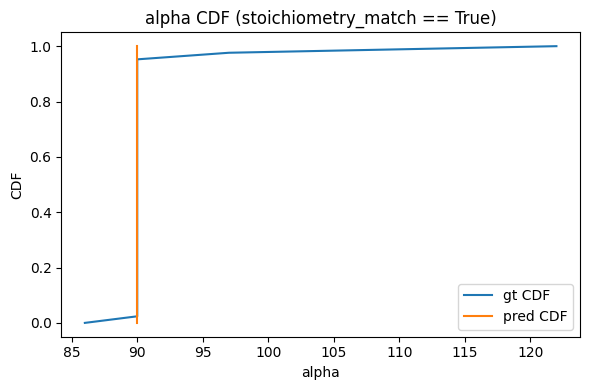

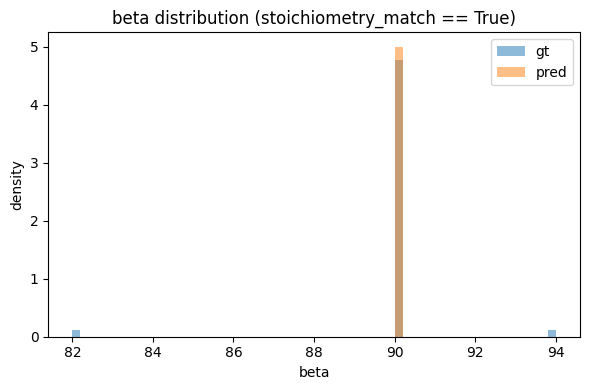

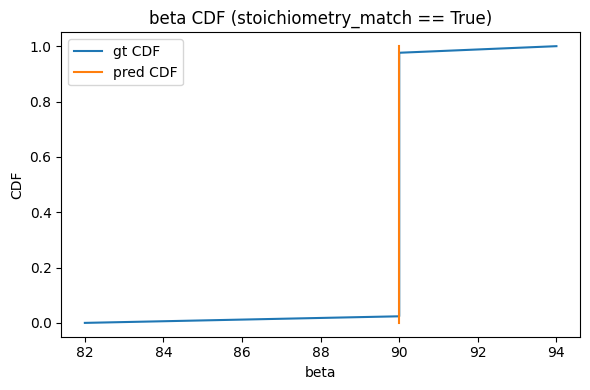

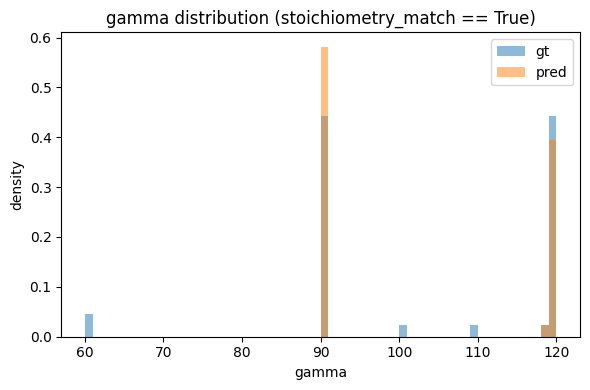

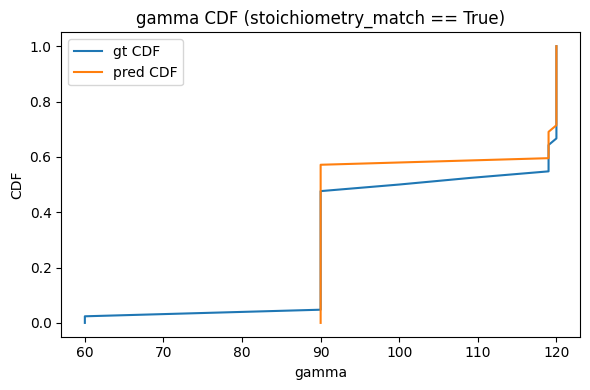

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Optional (recommended) for KLD and Wasserstein (EMD in 1D)
from scipy.stats import wasserstein_distance

# -----------------------
# Load + filter
# -----------------------
csv_path = "knc6.csv"  # <-- change
df = pd.read_csv(csv_path)

# normalize stoichiometry_match to bool if needed
if df["stoichiometry_match"].dtype == object:
    df["stoichiometry_match"] = df["stoichiometry_match"].astype(str).str.lower().map({"true": True, "false": False})

df_m = df[df["stoichiometry_match"] == True].copy()

params = ["a", "b", "c", "alpha", "beta", "gamma"]

# -----------------------
# Helpers: histogram-based KLD and histogram-based EMD (1D)
# -----------------------
def pmf_from_hist(x, bins):
    """Return a probability mass function over bins (sum=1)."""
    h, _ = np.histogram(x, bins=bins)
    p = h.astype(float)
    p = p / max(p.sum(), 1.0)
    return p

def kld(p, q, eps=1e-12):
    """
    KL(p || q) for discrete PMFs.
    eps smoothing prevents log(0) / division by zero.
    """
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)
    p = p + eps
    q = q + eps
    p /= p.sum()
    q /= q.sum()
    return float(np.sum(p * np.log(p / q)))

def emd_1d_from_hist(p, q, bin_edges):
    """
    1D Earth Mover's Distance between two histograms (PMFs) using Wasserstein.
    We treat each bin center as a support point with weights p, q.
    """
    centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    return float(wasserstein_distance(centers, centers, u_weights=p, v_weights=q))

# -----------------------
# Compute distributional metrics per parameter
# -----------------------
rows = []
for p in params:
    gt = pd.to_numeric(df_m[f"{p}_gt"], errors="coerce").dropna().to_numpy()
    pr = pd.to_numeric(df_m[f"{p}_pred"], errors="coerce").dropna().to_numpy()

    # Align lengths only by available values; distributional metrics do not require pairing
    if len(gt) == 0 or len(pr) == 0:
        rows.append({"param": p, "n_gt": len(gt), "n_pred": len(pr), "KLD(gt||pred)": np.nan, "KLD(pred||gt)": np.nan, "JSD": np.nan, "EMD": np.nan})
        continue

    # Common bins over the union range (like the paper’s min/max range reporting)
    lo = np.nanmin([gt.min(), pr.min()])
    hi = np.nanmax([gt.max(), pr.max()])

    # Choose bins (you can tune this; Freedman–Diaconis also possible)
    nbins = 50 if p in ["a","b","c"] else 60
    bins = np.linspace(lo, hi, nbins + 1)

    P = pmf_from_hist(gt, bins)
    Q = pmf_from_hist(pr, bins)

    # KL is asymmetric; paper doesn’t state direction, so compute both
    kl_pq = kld(P, Q)
    kl_qp = kld(Q, P)

    # Jensen–Shannon divergence (symmetric, bounded) can be nice to report
    M = 0.5 * (P + Q)
    jsd = 0.5 * kld(P, M) + 0.5 * kld(Q, M)

    emd = emd_1d_from_hist(P, Q, bins)

    rows.append({
        "param": p,
        "n_gt": len(gt),
        "n_pred": len(pr),
        "KLD(gt||pred)": kl_pq,
        "KLD(pred||gt)": kl_qp,
        "JSD": jsd,
        "EMD": emd,
        "min_union": lo,
        "max_union": hi,
    })

metrics_df = pd.DataFrame(rows).set_index("param")
print(metrics_df)

# -----------------------
# Plots: normalized histograms + CDF (distribution comparison)
# -----------------------
for p in params:
    gt = pd.to_numeric(df_m[f"{p}_gt"], errors="coerce").dropna().to_numpy()
    pr = pd.to_numeric(df_m[f"{p}_pred"], errors="coerce").dropna().to_numpy()
    if len(gt) == 0 or len(pr) == 0:
        continue

    lo = np.nanmin([gt.min(), pr.min()])
    hi = np.nanmax([gt.max(), pr.max()])
    nbins = 50 if p in ["a","b","c"] else 60
    bins = np.linspace(lo, hi, nbins + 1)

    # Normalized hist overlays (like Fig. 2 style)
    fig, ax = plt.subplots(figsize=(6,4))
    ax.hist(gt, bins=bins, density=True, alpha=0.5, label="gt")
    ax.hist(pr, bins=bins, density=True, alpha=0.5, label="pred")
    ax.set_title(f"{p} distribution (stoichiometry_match == True)")
    ax.set_xlabel(p)
    ax.set_ylabel("density")
    ax.legend()
    plt.tight_layout()
    plt.show()

    # CDF overlay (often easier to see shifts than histograms)
    fig, ax = plt.subplots(figsize=(6,4))
    gt_sorted = np.sort(gt)
    pr_sorted = np.sort(pr)
    ax.plot(gt_sorted, np.linspace(0,1,len(gt_sorted), endpoint=True), label="gt CDF")
    ax.plot(pr_sorted, np.linspace(0,1,len(pr_sorted), endpoint=True), label="pred CDF")
    ax.set_title(f"{p} CDF (stoichiometry_match == True)")
    ax.set_xlabel(p)
    ax.set_ylabel("CDF")
    ax.legend()
    plt.tight_layout()
    plt.show()
